In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf 
from pandas_datareader import data as pdr
yf.pdr_override()

In [11]:
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.figsize']=[8,6]

In [14]:
tickers =['SPY', 'TLT', 'RWR']

In [22]:
dataset= yf.download(tickers, start='2010-01-01', end='2022-12-31')['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [23]:
import pandas as pd

In [24]:
datasetreturns= np.log(dataset/dataset.shift(1))

In [25]:
import numpy as np

In [26]:
import matplotlib.pyplot as plt

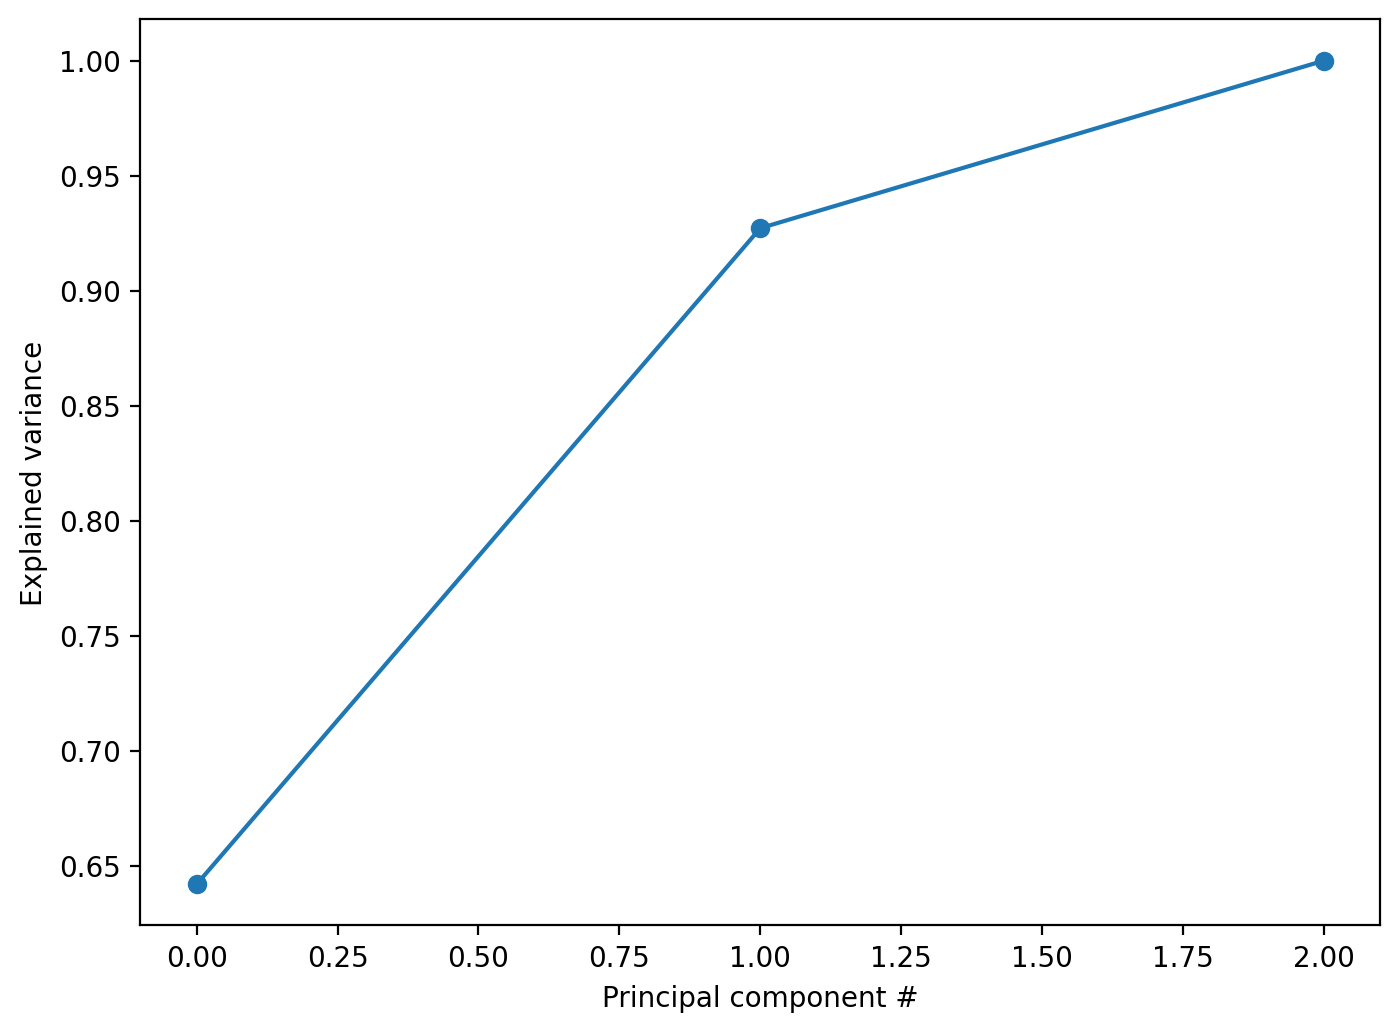

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(StandardScaler().fit_transform(datasetreturns.dropna()))
expl_var = pca.explained_variance_ratio_
pd.DataFrame(expl_var.cumsum()).plot(style='-o', legend=False)
plt.xlabel('Principal component #')
plt.ylabel('Explained variance')
plt.show()
     

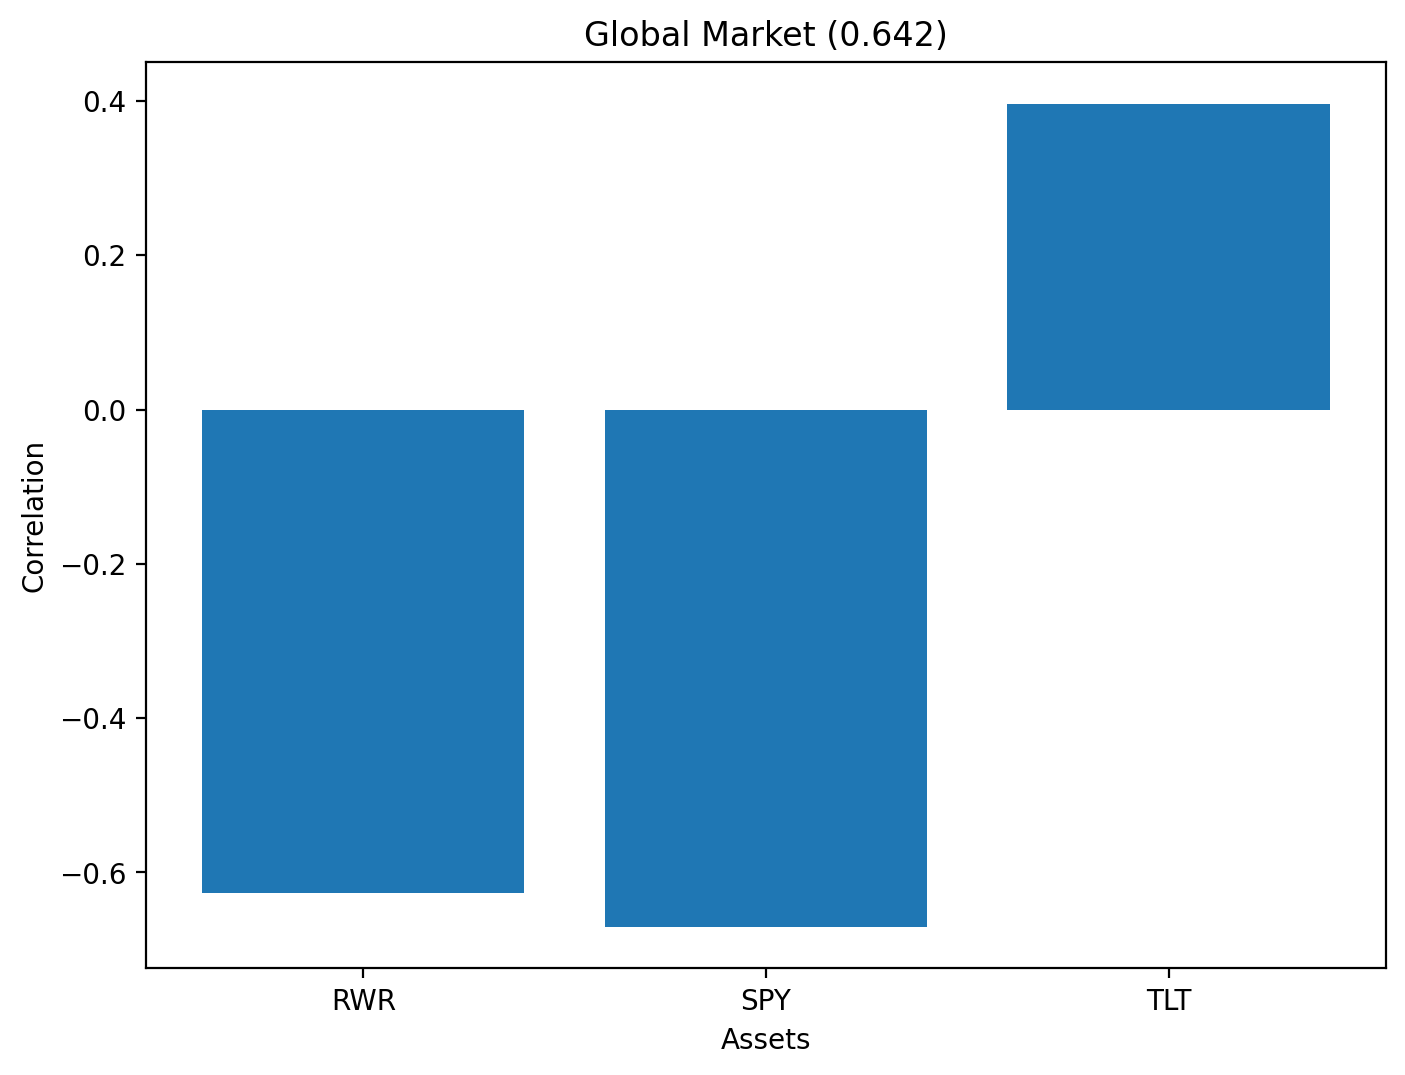

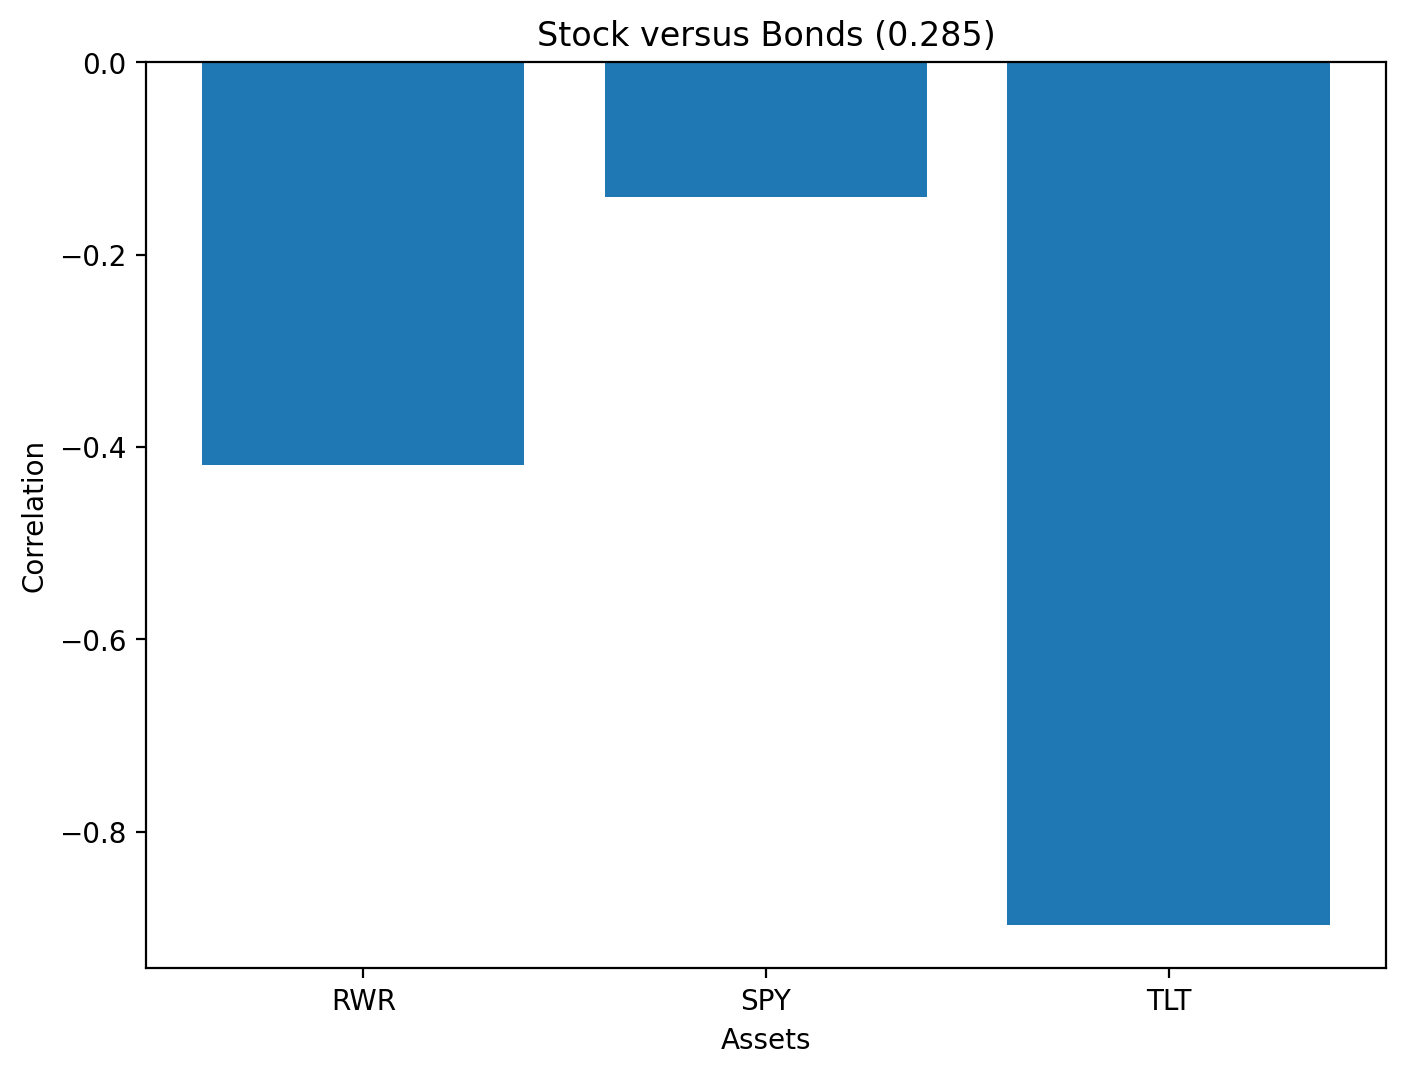

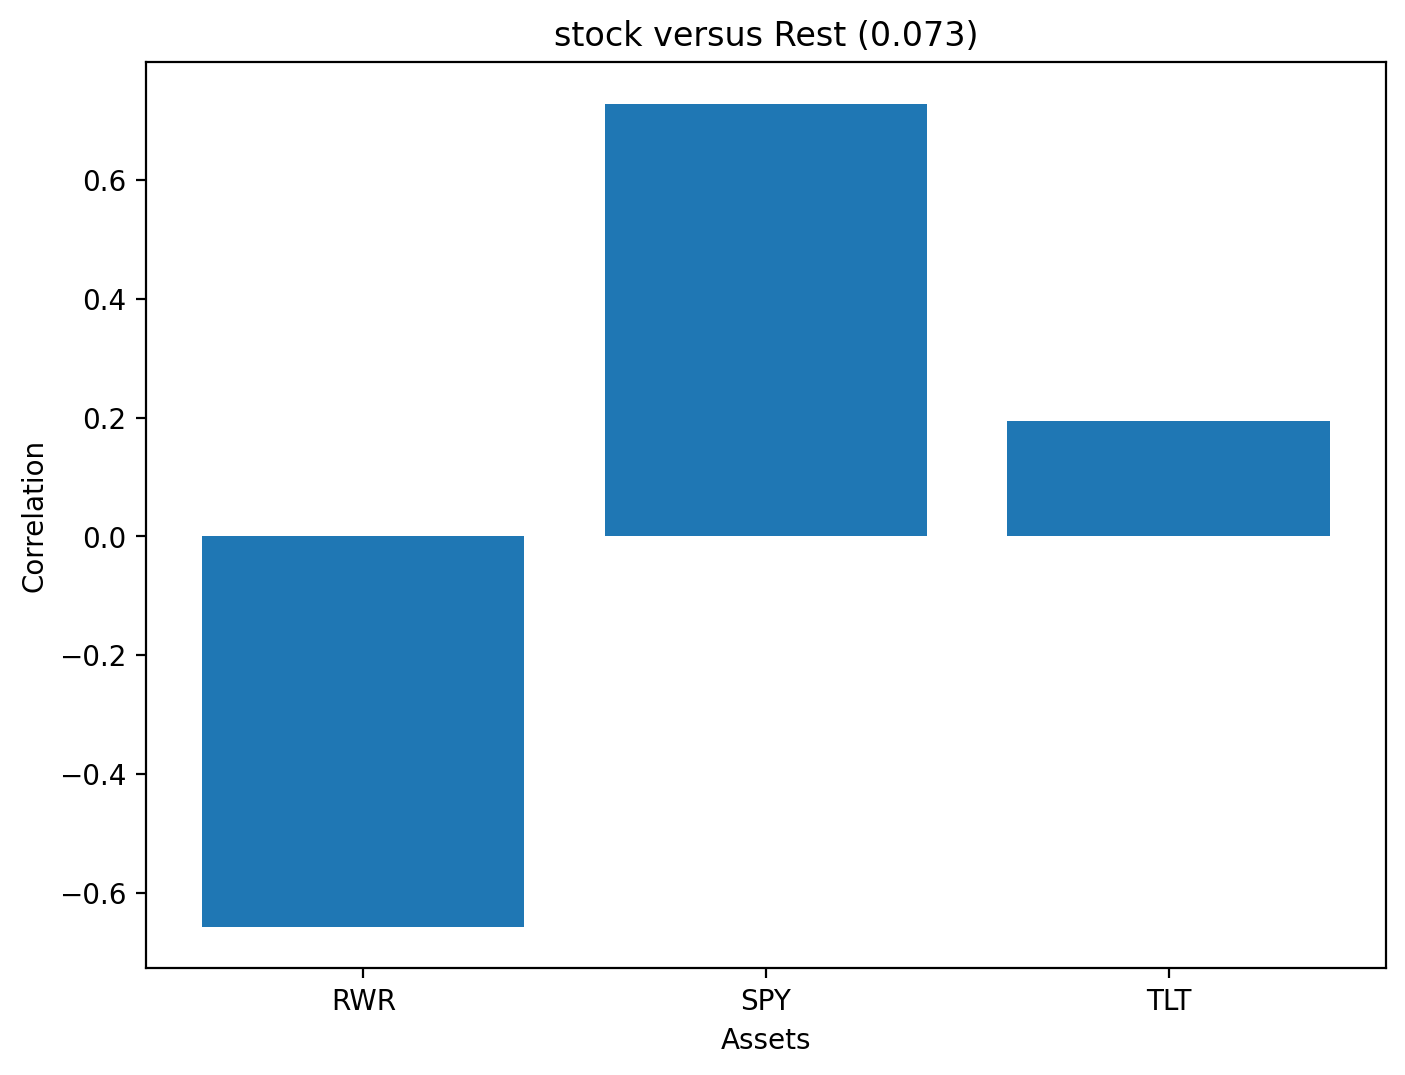

In [28]:
component_labels = {
    0: f'Global Market ({round(expl_var[0], 3)})',
    1: f'Stock versus Bonds ({round(expl_var[1], 3)})',
    2: f'stock versus Rest ({round(expl_var[2], 3)})',
    
}

for n, component in enumerate(pca.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xticks(dataset.columns)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

In [29]:
pd.DataFrame({
    'Eigenvalues': pca.explained_variance_, 
    'Retain?': pca.explained_variance_ > 1,
    'Explained Variance': expl_var,
    'Cumulative Expl. Var.': expl_var.cumsum()
})

,Eigenvalues,Retain?,Explained Variance,Cumulative Expl. Var.
0,1.926514,True,0.641975,0.641975
1,0.855866,False,0.285201,0.927176
2,0.218537,False,0.072824,1.000000


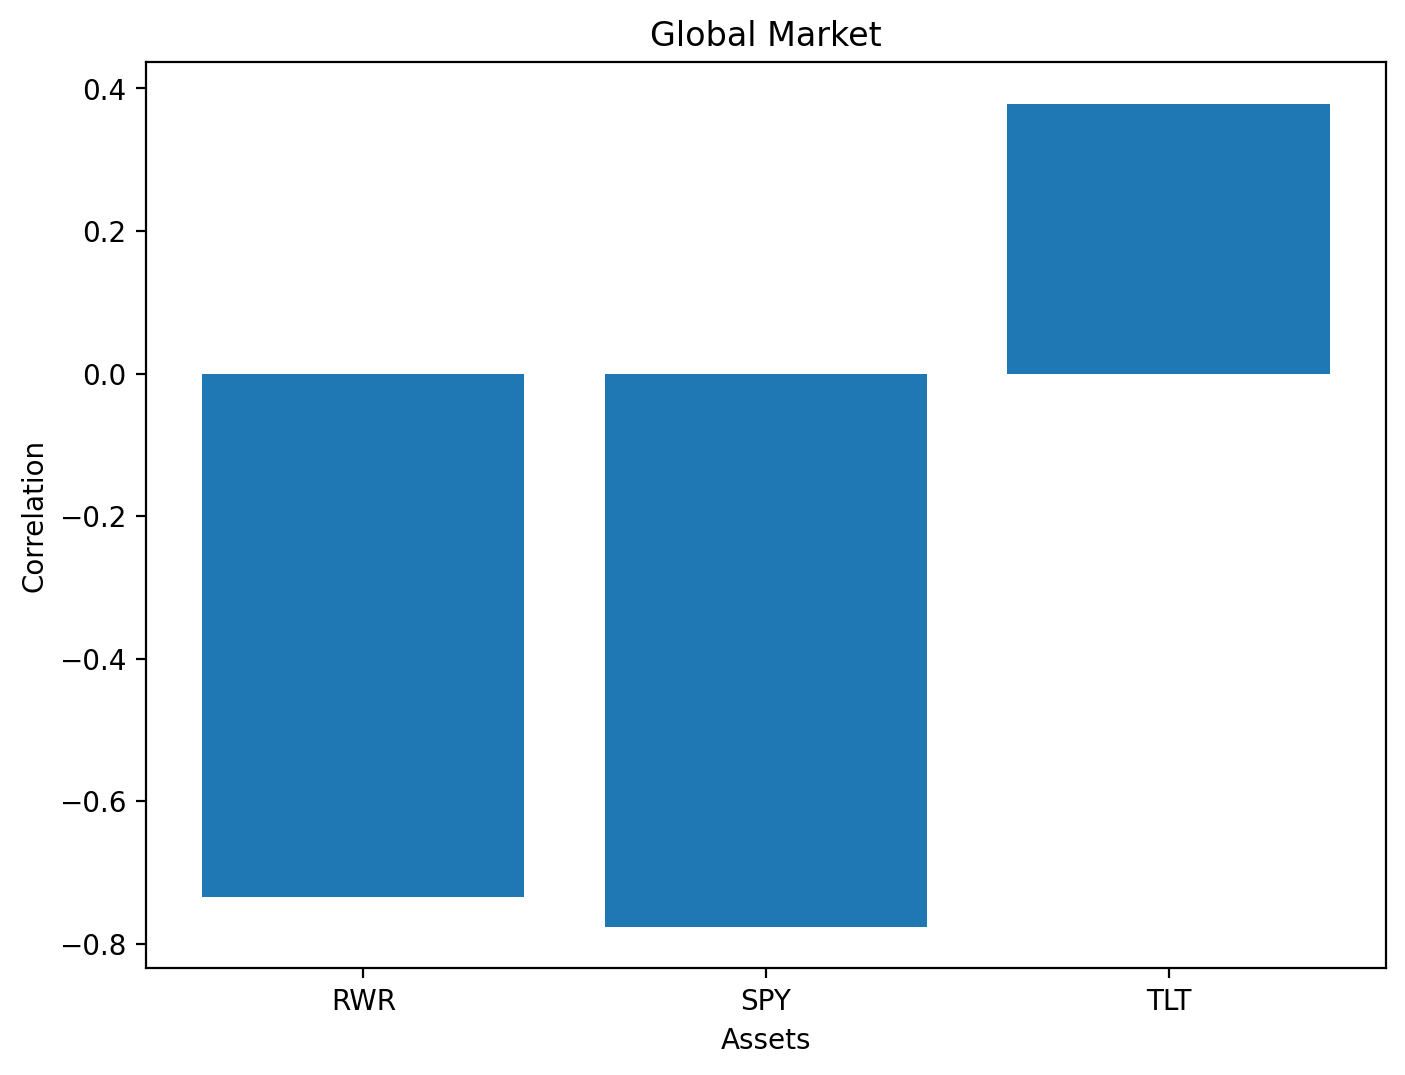

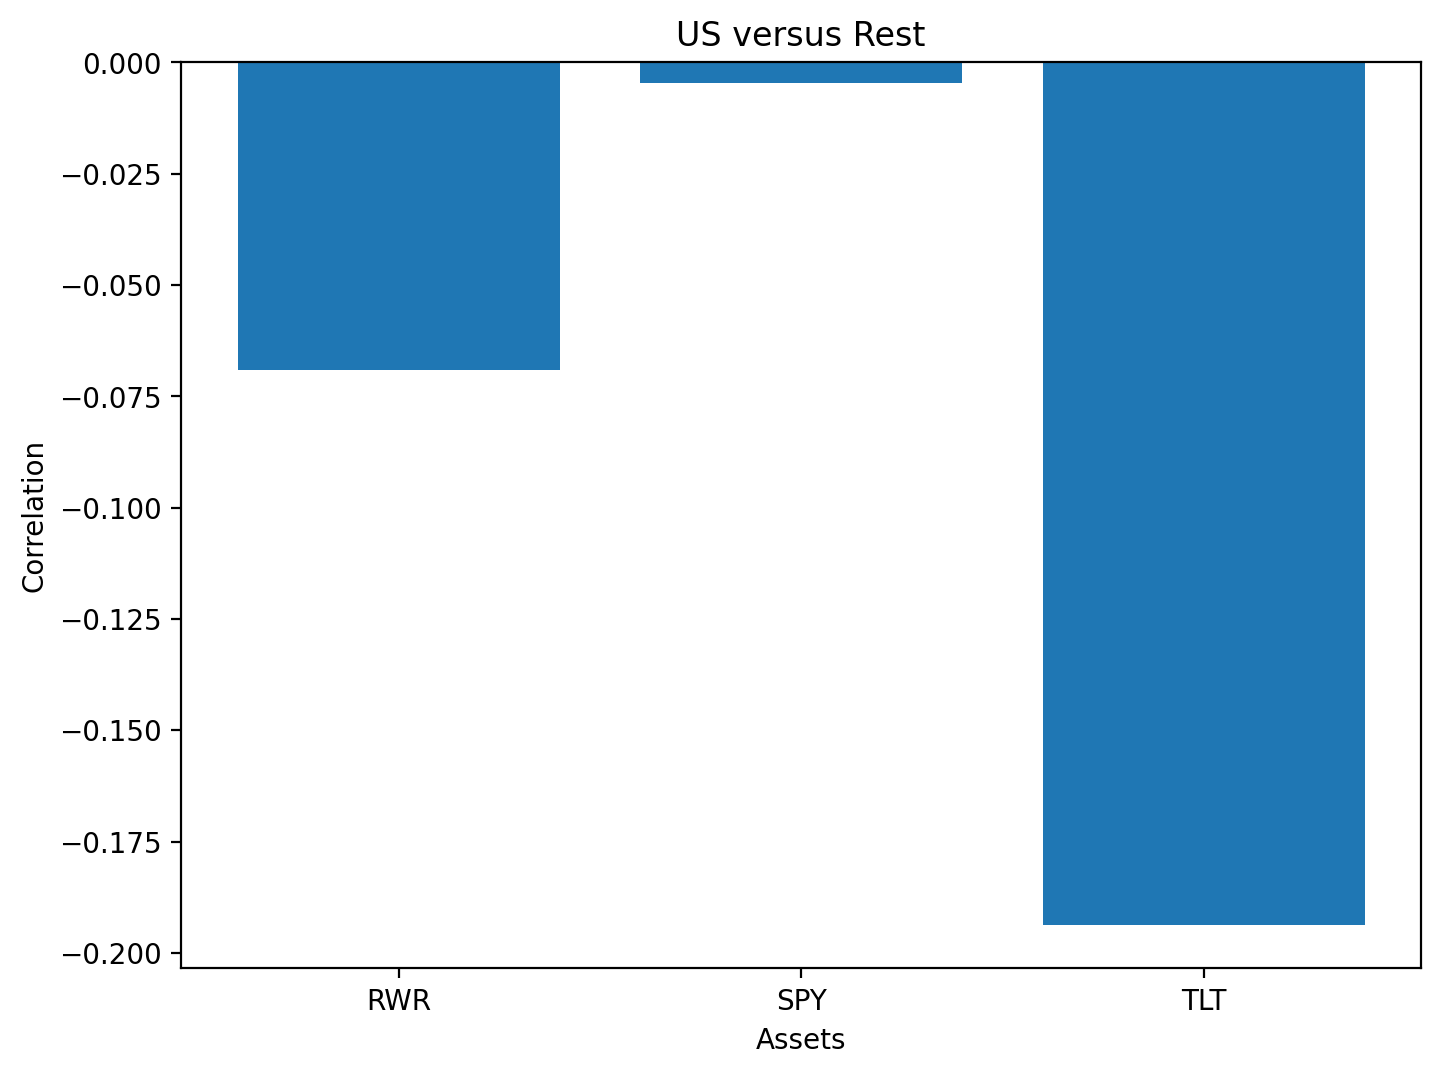

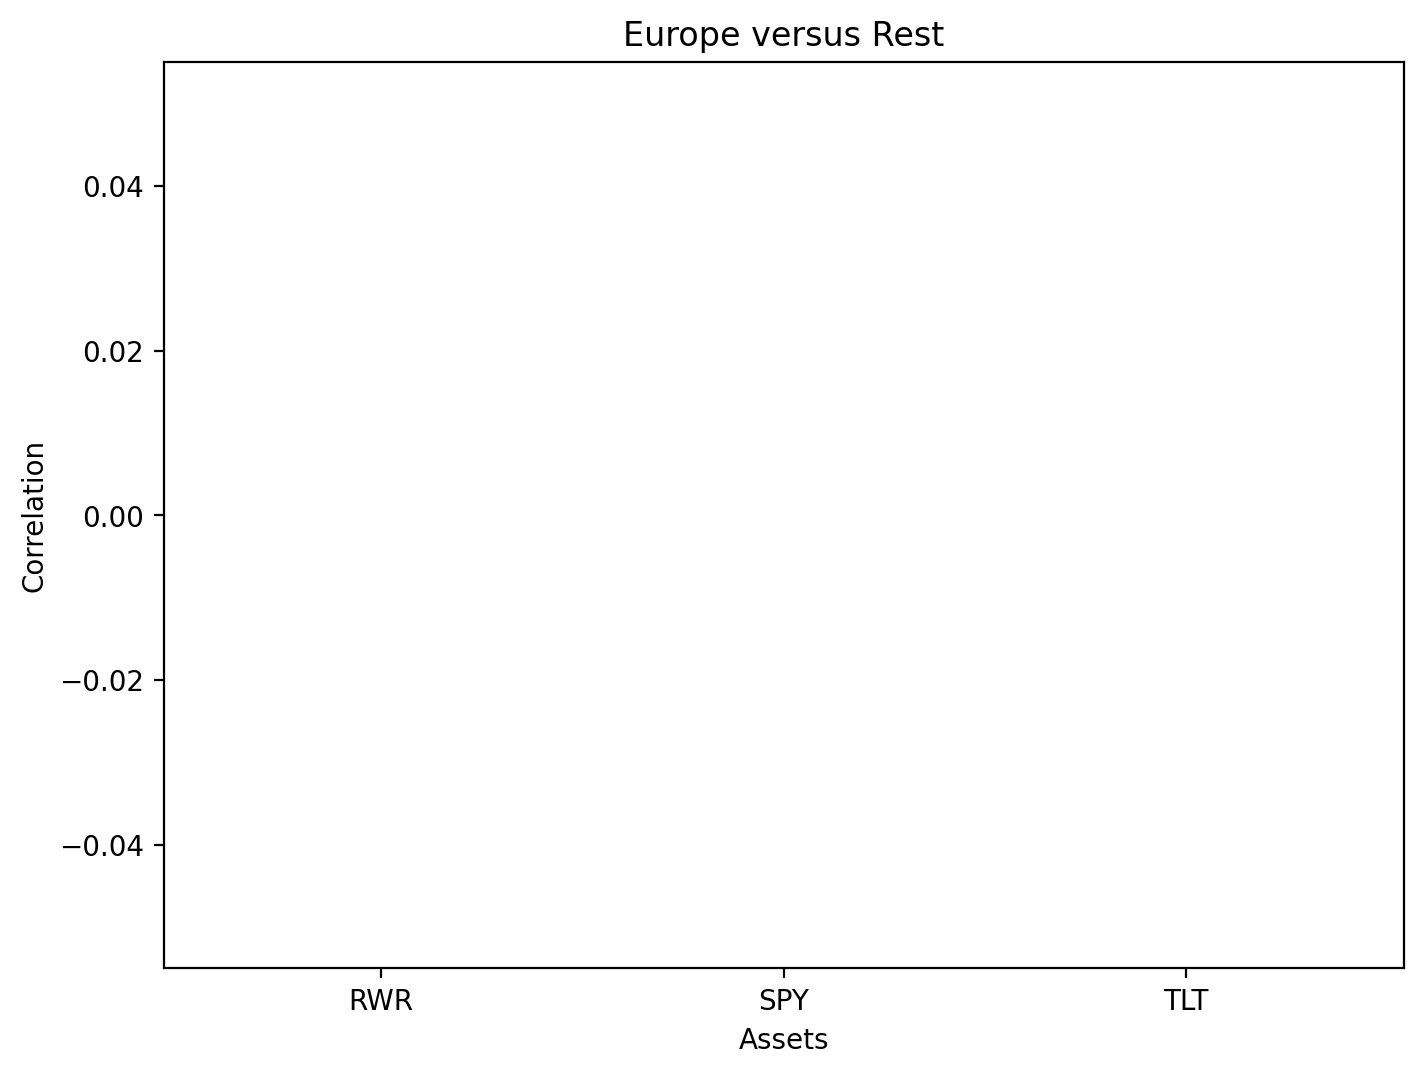

In [30]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis().fit(StandardScaler().fit_transform(datasetreturns.dropna()))

component_labels = {
    0: f'Global Market',
    1: f'US versus Rest',
    2: f'Europe versus Rest',
}

for n, component in enumerate(fa.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

In [31]:
from itertools import combinations

# https://github.com/vinecopulib/pyvinecopulib
import pyvinecopulib as pv

# pyvinecopulib expects data to be pseudo-observations
# borrowing computer from https://github.com/DanielBok/copulae
from copulae.core import pseudo_obs

results = []
for pair in list(combinations(datasetreturns.dropna().columns, 2)):

    data = pseudo_obs(datasetreturns.dropna()[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    pair_results = {'pair': pair}
    for family in family_set:
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results[family.name.capitalize()] = copula.loglik()
    results.append(pair_results)
    
results = pd.DataFrame(results).set_index('pair')
     

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


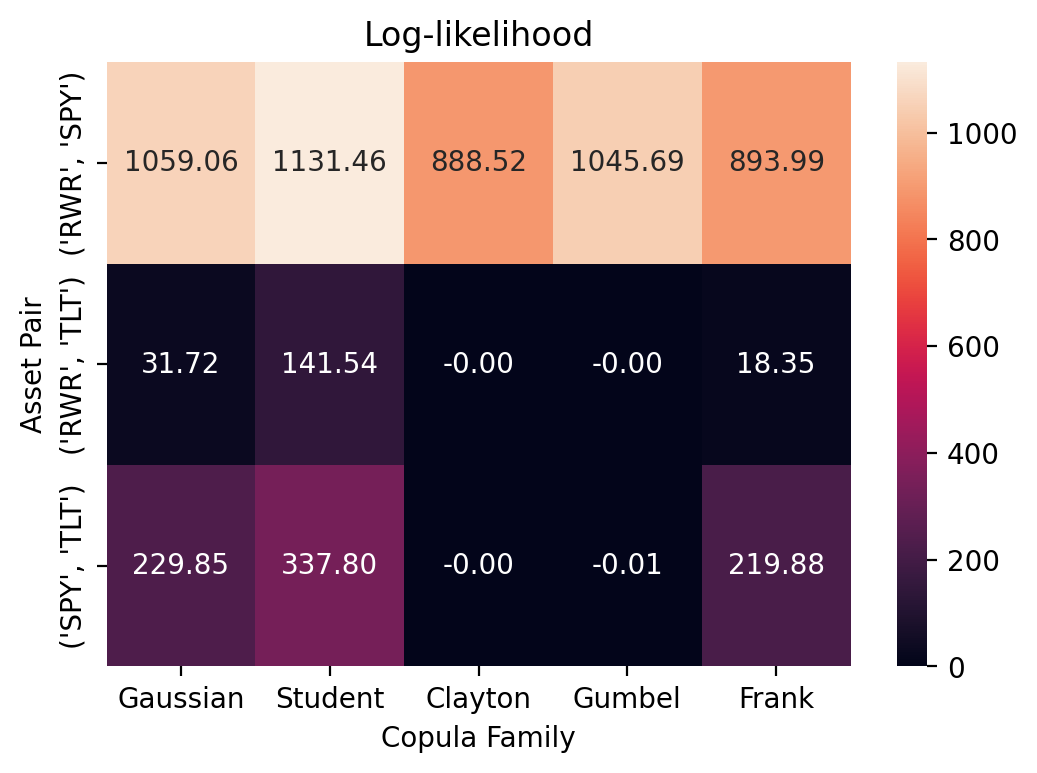

In [32]:
import seaborn as sb 
plt.figure(figsize=(6,4))
sb.heatmap(results.dropna(), annot=True, fmt='.2f')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

In [33]:
datasetreturns=datasetreturns.dropna()

In [34]:
results.idxmax(axis=1).value_counts()


Student    3
dtype: int64

In [35]:
def z_pdf(copula, x1, x2, zclip=30):
    """computes third dimension using pdf of fitted copula
    very rudimentary (slow!) implementation which could probably be vectorised
    inspired by https://github.com/blent-ai/pycopula/blob/master/pycopula/visualization.py
    """
    
    x1 = np.sort(x1)
    x2 = np.sort(x2)
    z= []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            row.append(min(copula.pdf([[x1[i], x2[j] ]])[0], zclip))
        z.append(row)

    return x1, x2, np.asarray(z)

best_pair = results.max(axis=1).idxmax()
best_data = pseudo_obs(datasetreturns[[best_pair[0], best_pair[1]]])

best_copula = pv.Bicop(family=pv.BicopFamily.student)
best_copula.fit(best_data)

x1, x2 = best_data.iloc[:, 0], best_data.iloc[:, 1]
x1_s, x2_s, z = z_pdf(best_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

In [36]:
best_pair

('RWR', 'SPY')

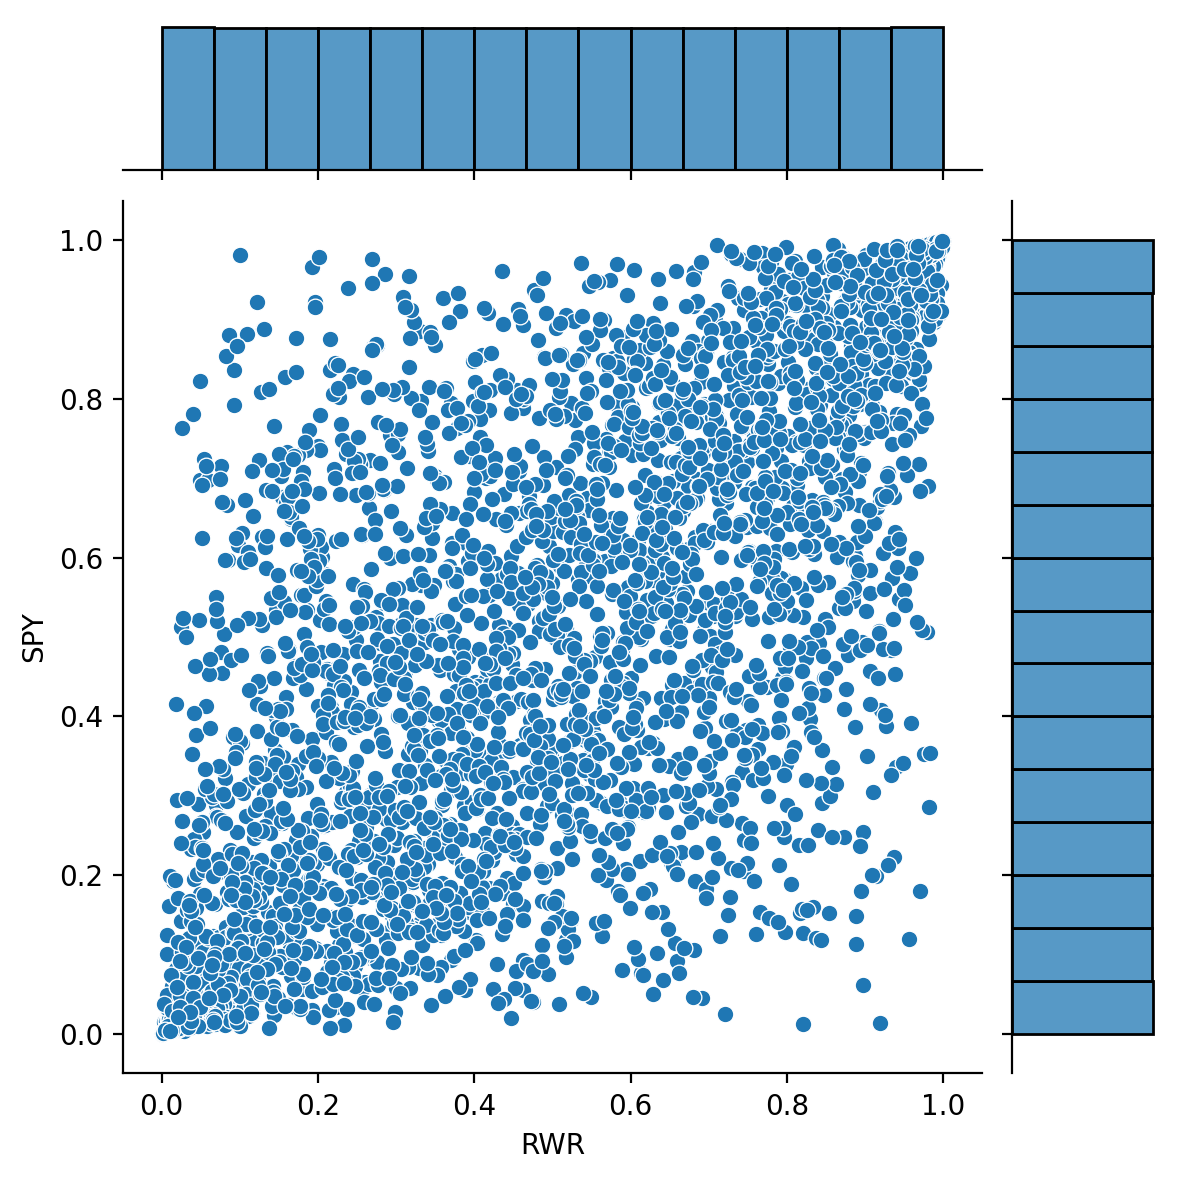

In [37]:
sb.jointplot(x=x1, y=x2, kind='scatter').set_axis_labels(best_pair[0], best_pair[1])
plt.show()

C:\Users\JAHANL~1\AppData\Local\Temp/ipykernel_8444/1942475716.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure())


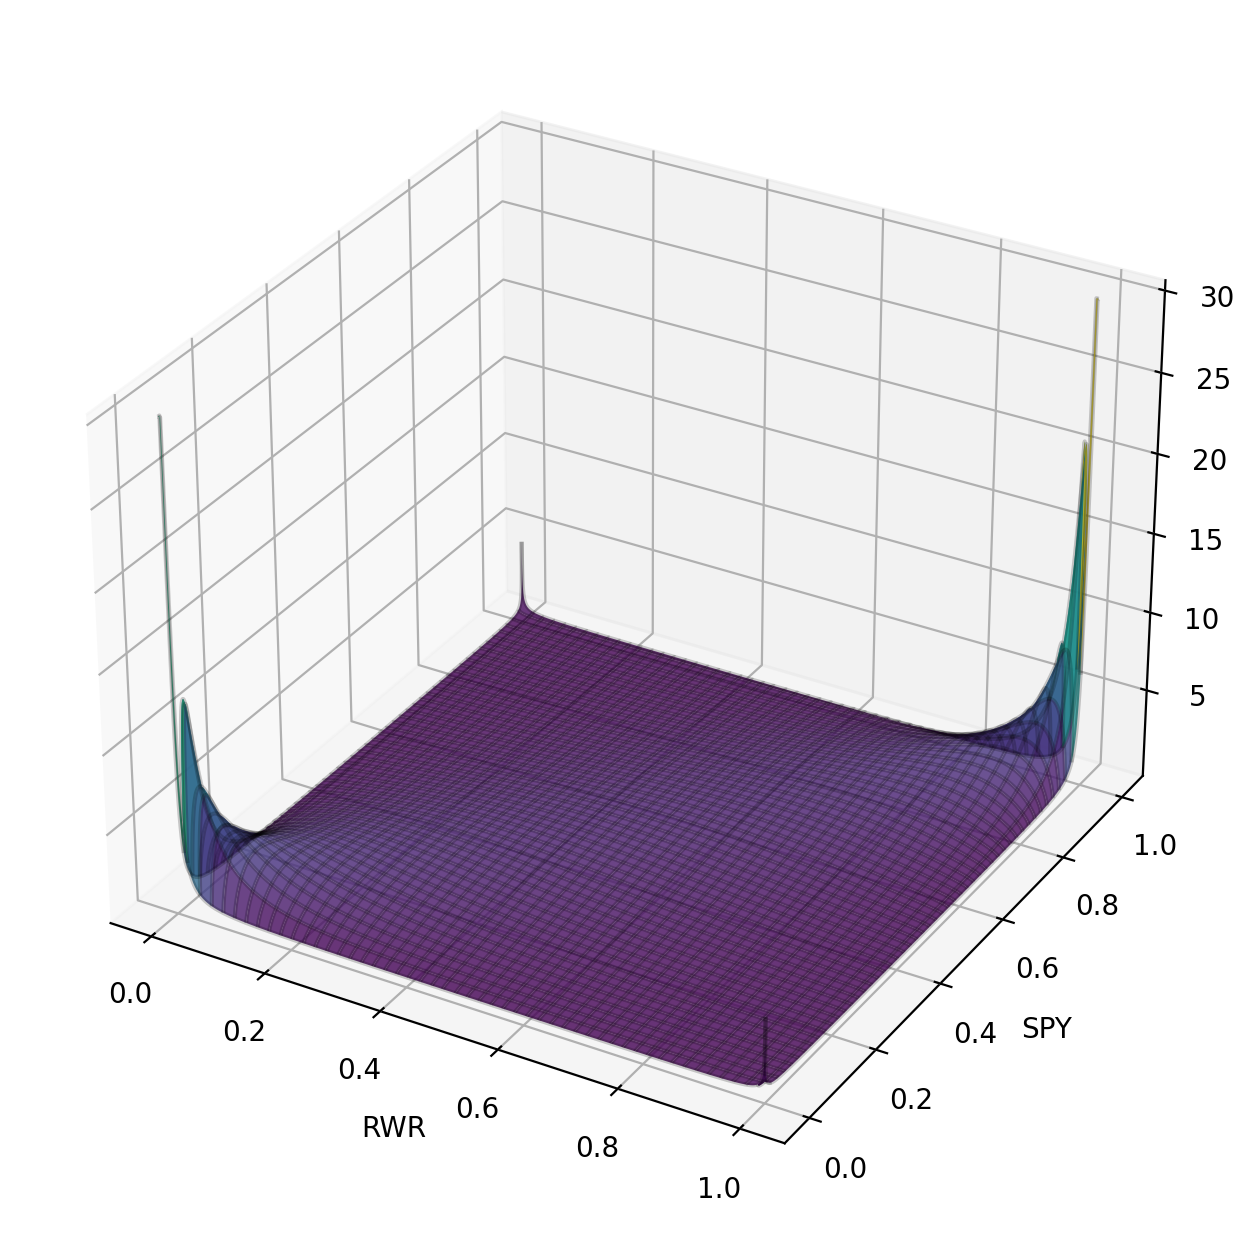

In [38]:
from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(best_pair[0])
ax.set_ylabel(best_pair[1])
plt.show()

C:\Users\jahan laptop\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


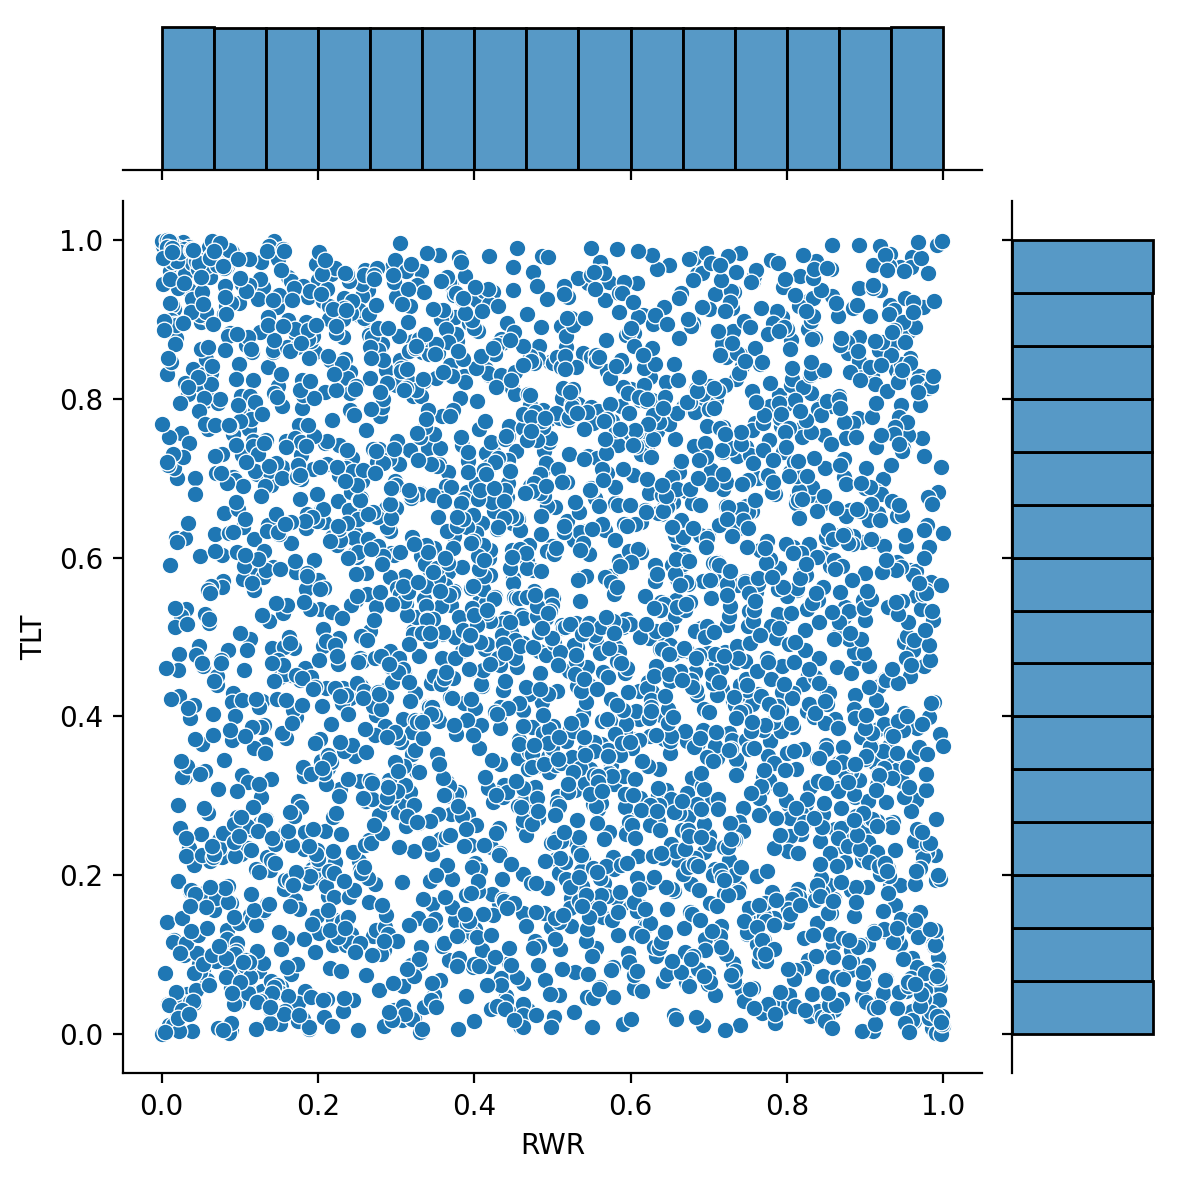

C:\Users\JAHANL~1\AppData\Local\Temp/ipykernel_8444/3115713894.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure())


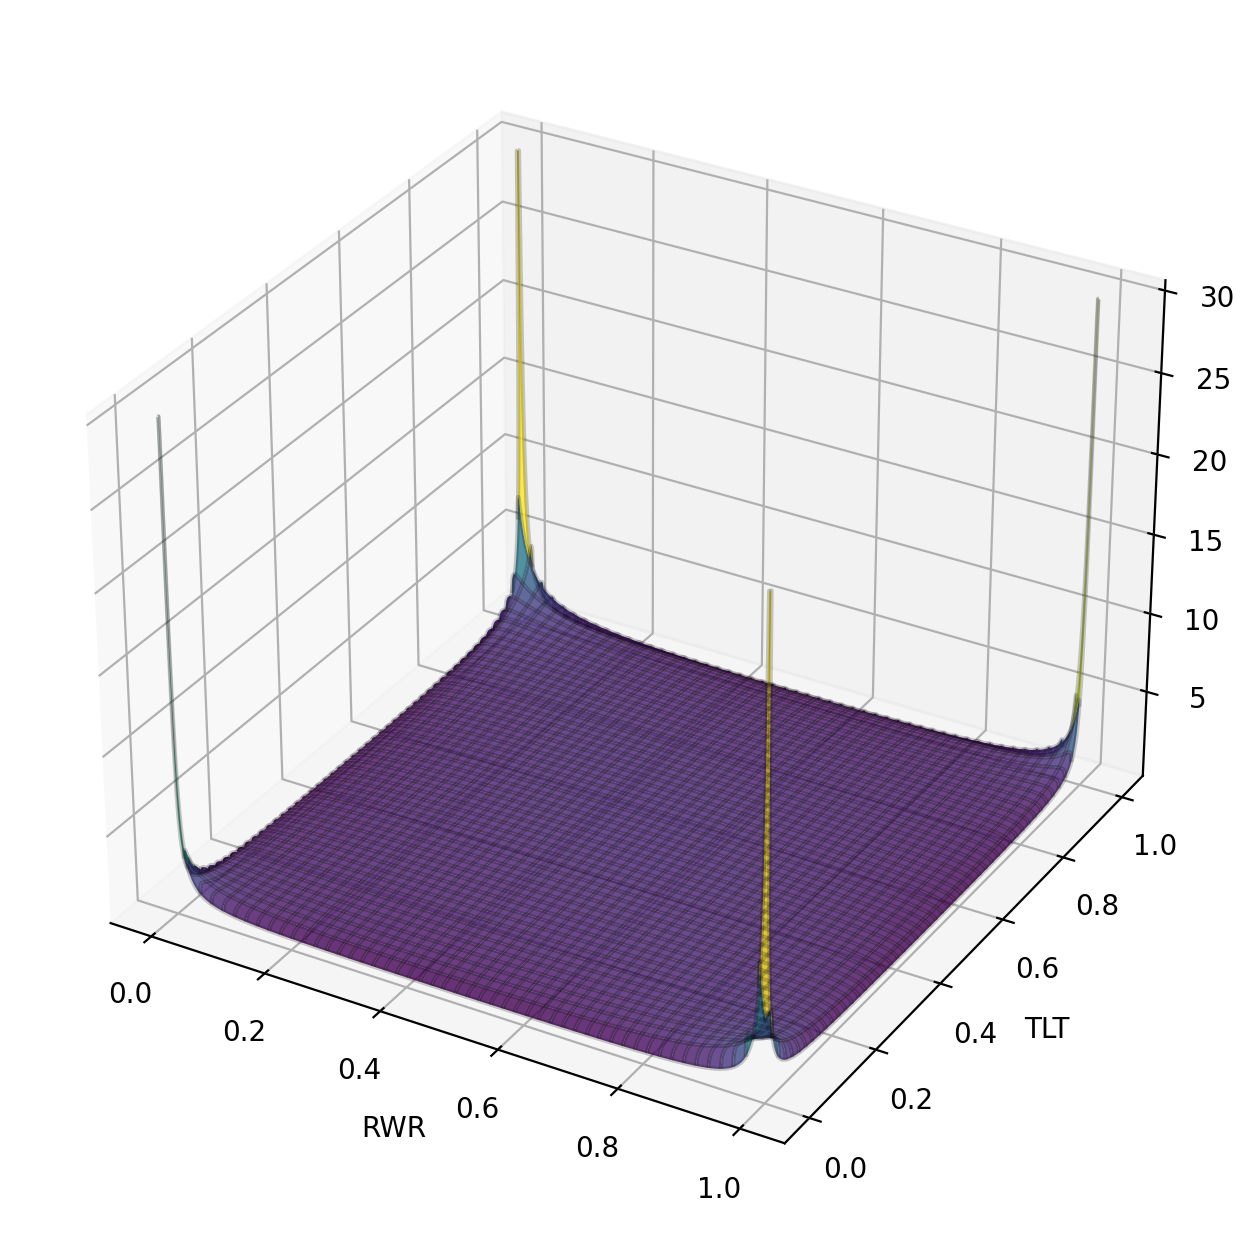

In [39]:
worst_pair = results.max(axis=1).idxmin()
worst_data = pseudo_obs(datasetreturns[[worst_pair[0], worst_pair[1]]])

worst_copula = pv.Bicop(family=pv.BicopFamily.student)
worst_copula.fit(worst_data)

x1, x2 = worst_data.iloc[:, 0], worst_data.iloc[:, 1]
x1_s, x2_s, z = z_pdf(worst_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

sb.jointplot(x1, x2, kind='scatter').set_axis_labels(worst_pair[0], worst_pair[1])
plt.show()

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(worst_pair[0])
ax.set_ylabel(worst_pair[1])
plt.show()

In [40]:
worst_data = pseudo_obs(datasetreturns[[worst_pair[0], worst_pair[1]]])


In [41]:
worst_copula = pv.Bicop(family=pv.BicopFamily.student)


In [42]:
worst_copula

<pyvinecopulib.Bicop>
Student, parameters =  0
50

In [43]:
otherdata= pseudo_obs(datasetreturns[[datasetreturns['SPY'], datasetreturns['TLT']]])


KeyError: "None of [Index([(0.01681754030038659, 0.002643504883816445, 0.000703521043772618, 0.004212732930085145, 0.0033222017163097887, 0.0013956969618706089, -0.009370091501854836, 0.00841062054882067, 0.0027008044389947345, -0.011287486679185802, 0.01241820532444219, -0.010220646036052472, -0.01941670755538394, -0.022544022857346538, 0.005114720264415117, -0.0041990414223391235, 0.004745657698780264, -0.011538738981991847, -0.010928224608384652, 0.015431027699976636, 0.012031441863452386, -0.004995505973052615, -0.03135224244859567, 0.002064904849784084, -0.00724552938341382, 0.012481844543095645, -0.0019608403224826115, 0.010412006564957513, -0.0008326631977905573, 0.015612750115312386, 0.004727373141484898, 0.005877741424418593, 0.0020717445667350165, 0.0001799337310508679, -0.01221922548568323, 0.00915567554915416, -0.0013548802822817294, 0.0006326530309692204, 0.010331124074469272, 0.002767220272408162, 0.0008903299476330007, 0.0030228897604135056, 0.014192485574185197, 0.00017512175262670817, 0.001661146774706366, 0.00444589789507881, 0.004166405078382821, 8.635827173676231e-05, 0.0002599611105710798, 0.007934436956160968, 0.0059099723911162725, -0.0005127551180677672, -0.005074235297831919, 0.0053318564274294445, 0.007008245485492738, -0.004866673786889459, -0.0016273629993500214, -0.0006000472003452971, 0.006327667012117266, 0.0006814267356488124, -0.0034131178848839537, 0.006814708649567028, 0.008116277724027187, 0.002354636493377815, -0.005728602050357701, 0.00345790058181156, 0.0065458413620432775, 0.0015881622583082157, 0.0007513395347008343, 0.011285533617172987, 0.0008247851606055507, -0.016040264423496806, 0.0037628224365670324, 0.008891507239228833, -0.0018219602250972684, 0.0029792027818863996, 0.006506851102337926, -0.0037836301919017905, -0.023934566066647504, 0.007567118391854047, 0.012320990635994728, -0.017106752958646082, 0.012878290909117757, -0.02379526639076166, -0.005974559295875676, -0.033777264613785045, -0.01498717096653204, 0.04309863601871707, -0.0028448993654792143, 0.013889240256495133, -0.012508749533534286, -0.01827094647179869, 0.0005269940130359041, -0.013696173600766897, -0.005710065845056803, -0.038490966133637096, 0.01449364878243391, -0.012913993226553842, 0.0010208710322264784, -0.006047079510286129, ...), (-0.0008901136330019747, 0.006437129721287575, -0.013476496874681066, 0.0016809565995634967, -0.0004480191345665346, -0.0055033419111924, 0.01697244229517056, -0.011693004072029911, 0.013905303403936359, 0.006167579614427852, -0.0028593191890234544, 0.010079890794409848, 0.004565922415701269, -0.0017361771085722788, -0.004576111684150804, 0.00032736713598146926, -0.0005461424894203958, -0.0005457339741871861, 0.008704147481670385, -0.009118152159013036, 0.002847425468145618, -0.011663997881235193, 0.01570373773256973, 0.002177138829790801, 0.001303335140237224, -0.010039414842325931, -0.00958786291070643, -0.005439693228789266, 0.00411098381282523, 0.0018823626822487703, -0.011463633829730393, -0.004037604252789643, 0.0053800579134008035, -0.004145847932069469, 0.015484106128485125, 0.002429128853660697, 0.005606327258743464, 0.0051413892298628845, -0.0004382089166036685, -0.0013140189292374957, -0.00252516777590022, 0.005261434705642498, -0.013205206226441698, -0.005221172469645607, 0.00022276675083723885, -0.0025642209137746795, 0.0036771322377002133, 0.006209091542748681, -0.001327464195601353, 0.007936599255776234, 0.004272474018400685, -0.003284960308710788, 0.000986304769670631, 0.0010953015384957323, -0.004717224894200419, -0.01842433424946185, -0.0064060464396532004, 0.002814499208108013, -0.00383006975493701, 0.0031552011754212633, 0.006838916257169424, -0.0024474338974950997, -0.016777812824111307, 0.0015990474824463866, 0.012702057182377267, 0.00045056490749846844, 0.0023628154440833216, 0.005268454695155578, 0.0032366383502621023, -0.007044634666929442, 0.0011204249643131145, 0.007260753093263321, -0.002451298954082789, 0.0035633267817852, 0.008192325234740835, -0.002981233224456176, -0.003545128640115189, 0.001109654330412693, 0.013979503000434192, -0.008562795466275473, 0.004180384583076904, 0.011462931154076633, -0.0013082296079295658, 0.017835860714285424, 0.005875400966602663, 0.03041966861161558, -0.012580733278973672, -0.02093226360086775, -0.0025676957257890374, -0.007634076515356338, 0.006562301877200621, 0.01722109470776103, -0.0036954564122717607, 0.015222755742733761, 0.0033287249797997885, 0.02086089234566354, 0.001016000581995446, -0.0034602479487180226, 0.004881887691832237, -0.0028448706867808607, ...)], dtype='object')] are in the [columns]"

In [44]:
import pyvinecopulib as pv

# pyvinecopulib expects data to be pseudo-observations
# borrowing computer from https://github.com/DanielBok/copulae
from copulae.core import pseudo_obs

results = []
for pair in list(combinations(datasetreturns.dropna().columns, 2)):

    data = pseudo_obs(datasetreturns.dropna()[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    pair_results = {'pair': pair}
    for family in family_set:
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results[family.name.capitalize()] = copula.loglik()
    results.append(pair_results)
    
results = pd.DataFrame(results).set_index('pair')
     

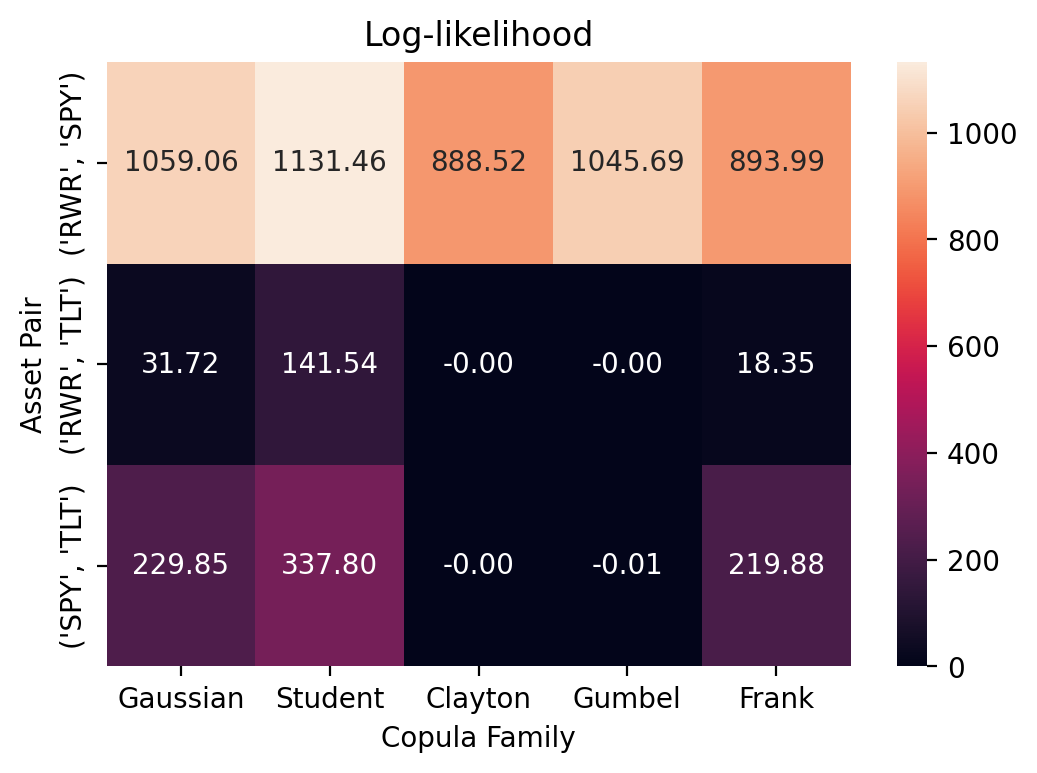

In [45]:
import seaborn as sb 
plt.figure(figsize=(6,4))
sb.heatmap(results.dropna(), annot=True, fmt='.2f')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

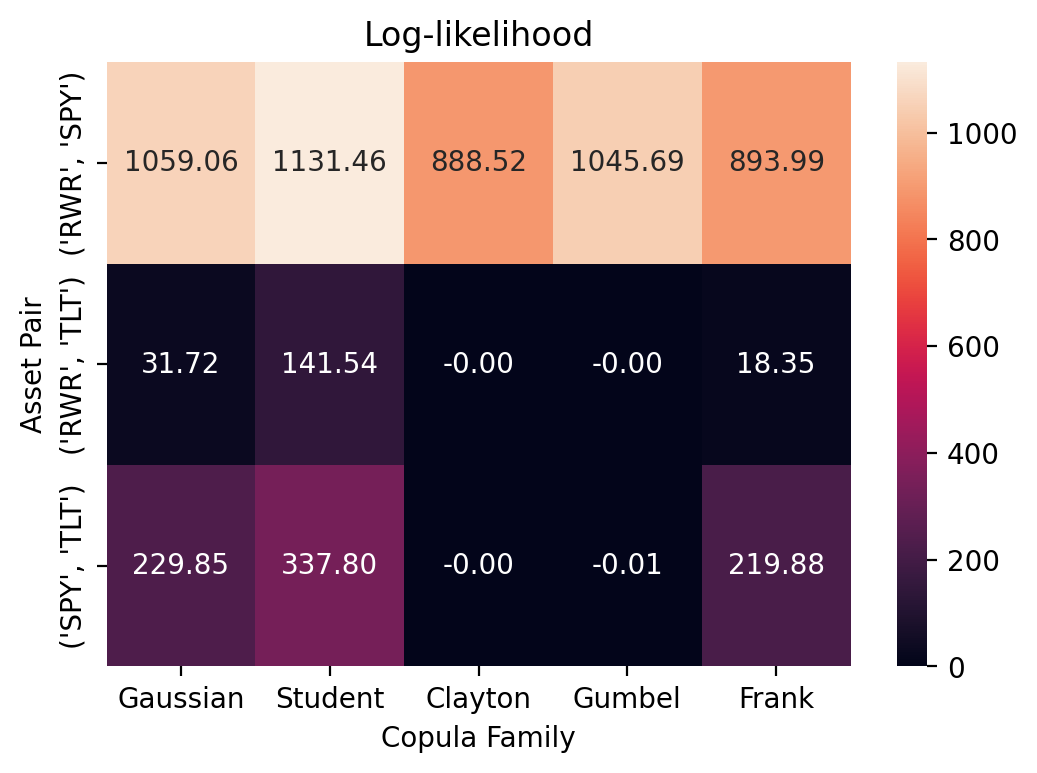

In [46]:
import seaborn as sb 
plt.figure(figsize=(6,4))
sb.heatmap(results.dropna(), annot=True, fmt='.2f')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

In [47]:
datasetreturns=datasetreturns.dropna()

In [48]:
results.idxmax(axis=1).value_counts()


Student    3
dtype: int64

In [49]:
def z_pdf(copula, x1, x2, zclip=30):
    """computes third dimension using pdf of fitted copula
    very rudimentary (slow!) implementation which could probably be vectorised
    inspired by https://github.com/blent-ai/pycopula/blob/master/pycopula/visualization.py
    """
    
    x1 = np.sort(x1)
    x2 = np.sort(x2)
    z= []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            row.append(min(copula.pdf([[x1[i], x2[j] ]])[0], zclip))
        z.append(row)

    return x1, x2, np.asarray(z)

best_pair = results.max(axis=1).idxmax()
best_data = pseudo_obs(datasetreturns[[best_pair[0], best_pair[1]]])

best_copula = pv.Bicop(family=pv.BicopFamily.student)
best_copula.fit(best_data)

x1, x2 = best_data.iloc[:, 0], best_data.iloc[:, 1]
x1_s, x2_s, z = z_pdf(best_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

In [50]:
best_pair = results.max(axis=1).idxmax()

In [51]:
def print_parameters(pair):
    results = []
    data = pseudo_obs(datasetreturns.dropna()[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    print(pair)
    for family in family_set:
        pair_results = {}
        pair_results['family'] = family.name.capitalize()
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results['rho/beta'] = copula.parameters[0][0]
        try:
            pair_results['v'] = copula.parameters[1][0]
        except:
            pair_results['v'] = pd.NA
        pair_results['log-likelihood'] = copula.loglik()
        results.append(pair_results)
        
    return pd.DataFrame(results).set_index('family')


print_parameters(('RWR', 'TLT'))
     

('RWR', 'TLT')


,rho/beta,v,log-likelihood
family,,,
Gaussian,-0.139163,<NA>,31.724680
Student,-0.104316,3.285667,141.537335
Clayton,0.000002,<NA>,-0.000112
Gumbel,1.000004,<NA>,-0.000843
Frank,-0.665905,<NA>,18.348036


In [52]:
print_parameters(('RWR', 'SPY'))


('RWR', 'SPY')


,rho/beta,v,log-likelihood
family,,,
Gaussian,0.691401,<NA>,1059.063452
Student,0.676434,3.929085,1131.460544
Clayton,1.333709,<NA>,888.519275
Gumbel,1.875786,<NA>,1045.693375
Frank,5.248952,<NA>,893.990890


In [53]:
print_parameters(('SPY', 'TLT'))


('SPY', 'TLT')


,rho/beta,v,log-likelihood
family,,,
Gaussian,-0.363246,<NA>,229.845153
Student,-0.367174,3.615962,337.804948
Clayton,0.000002,<NA>,-0.001224
Gumbel,1.000005,<NA>,-0.005709
Frank,-2.362993,<NA>,219.876953


In [54]:
from scipy import stats

pd.DataFrame(
    {'Kurtosis': stats.kurtosis(datasetreturns)},
    index=dataset.columns
).sort_values(by='Kurtosis')
     

,Kurtosis
TLT,4.138029
SPY,11.527605
RWR,21.358598


In [55]:
from scipy import stats

pd.DataFrame(
    {'Skewness': stats.skew(datasetreturns)},
    index=dataset.columns
).sort_values(by='Skewness')
     

,Skewness
RWR,-1.327428
SPY,-0.729654
TLT,-0.026075


In [56]:
from scipy import stats

pd.DataFrame(
    {'Mean': np.mean(datasetreturns)},
    index=dataset.columns
).sort_values(by='Mean')
     

,Mean
TLT,0.000135
RWR,0.000308
SPY,0.000453


In [57]:
from scipy import stats

pd.DataFrame(
    {'Max': np.max(datasetreturns)},
    index=dataset.columns
).sort_values(by='Max')
     

,Max
TLT,0.072503
SPY,0.086731
RWR,0.090170


In [58]:
datasetreturns.describe()

,RWR,SPY,TLT
count,3272.000000,3272.000000,3272.000000
mean,0.000308,0.000453,0.000135
std,0.013860,0.011131,0.009511
min,-0.202247,-0.115887,-0.069010
25%,-0.005650,-0.003735,-0.005493
50%,0.000920,0.000655,0.000562
75%,0.007121,0.005736,0.005751
max,0.090170,0.086731,0.072503
